**Author:** Fuad Al Abir \\
**Date:** 5 September 2021 \\
**Project Title:** Biomarker Identification by Reversing the Learning Mechanism of Autoencoder and Recursive Feature Elimination \\
**Abstract:** RNA-Seq has made significant contributions to various fields, particularly in cancer research. Recent studies on differential gene expression analysis and the discovery of novel cancer biomarkers have used RNA-Seq data extensively. New biomarker identification is essential for moving cancer research forward, and early cancer diagnosis improves patients' chances of recovery and increases life expectancy. There is an urgency and scope of improvement in both sections. In this paper, we developed an autoencoder-based biomarker identification method successfully applied to the UCI gene expression cancer RNA-Seq dataset consisting of five cancerous tumor types. By reversing the learning mechanism of the trained autoencoders, we devised an explainable post hoc methodology for identifying the influential genes with a high likelihood of becoming biomarkers. We applied recursive feature elimination to shorten the list further and presented a list of 18 potential biomarkers that are 100.0 percent accurate in identifying cancer types using support vector machine. Furthermore, we have compiled and validated separate lists of potential biomarkers for each cancer type. Our results outperform the state-of-the-art methods and confirm the potentiality of the newly identified biomarkers and the efficacy of the biomarker identification procedure. \\

> this notebook will take around 50 minuites to run on google colab with Tesla K80 GPU. thanks google for this support.

### `section 0 - preparation`

> the sections in this notebook are independent, though running section 0 is necessary for running the sections from 1 to n.


#### `downloading dataset`

In [24]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00401/TCGA-PANCAN-HiSeq-801x20531.tar.gz
!gunzip TCGA-PANCAN-HiSeq-801x20531.tar.gz
!tar xopf TCGA-PANCAN-HiSeq-801x20531.tar
!mv TCGA-PANCAN-HiSeq-801x20531 dataset
!rm -rf sample_data TCGA-PANCAN-HiSeq-801x20531.tar

--2021-09-06 13:37:44--  https://archive.ics.uci.edu/ml/machine-learning-databases/00401/TCGA-PANCAN-HiSeq-801x20531.tar.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72856320 (69M) [application/x-httpd-php]
Saving to: ‘TCGA-PANCAN-HiSeq-801x20531.tar.gz’

TCGA-PANCAN-HiSeq-8 100%[===================>]  69.48M  92.0MB/s    in 0.8s    

2021-09-06 13:37:45 (92.0 MB/s) - ‘TCGA-PANCAN-HiSeq-801x20531.tar.gz’ saved [72856320/72856320]



#### `importing libraries`

In [3]:
import time

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rc, font_manager
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style('white')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn import metrics
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score # precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping

# import statistics
# from mlxtend.plotting import plot_confusion_matrix

#### `utility`

In [22]:
def read_dataset(path):
    print('reading data...', end=' ')
    X = pd.read_csv(f'{path}/data.csv')
    X = X.drop(columns=['Unnamed: 0'])
    print(f'finished with shape: {X.shape} and type {type(X)}.')

    print('reading labels...', end=' ')
    y = pd.read_csv(f'{path}/labels.csv')
    y = y.drop(columns=['Unnamed: 0'])
    y.columns = ['type']
    print(f'finished with shape: {y.shape} and type {type(y)}.')
    return X, y

def drop_cols_minmax(df):
    n_cols = df.shape[1]
    print(f'> input shape :: {df.shape}')
    deleted_genes = list(df.columns[df.min() == df.max()])
    print('> deleting columns with no impact (min==max) ...', deleted_genes)
    df = df.loc[:, (df.max() != df.min())]
    print('> total deleted cols ::', n_cols - df.shape[1])
    print(f'> output shape :: {df.shape}')
    return df, deleted_genes

In [4]:
# TODO
# to generate the plots with New Times Roman, we have to run the following snippets to
# install the fonts and restart runtime (continuously) until the fonts are working perfectly.


In [5]:
# TODO
# here is a demo plot to check if the fonts are installed perfectly.


### `section 1 - training the autoencoders`

> please execute section 0 first and then proceed to execue the following section.

#### `exploratory data analysis`

In [6]:
X, y = read_dataset('dataset')

reading data... finished with shape: (801, 20531) and type <class 'pandas.core.frame.DataFrame'>.
reading labels... finished with shape: (801, 1) and type <class 'pandas.core.frame.DataFrame'>.


In [7]:
X.head(3)

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,gene_10,gene_11,gene_12,gene_13,gene_14,gene_15,gene_16,gene_17,gene_18,gene_19,gene_20,gene_21,gene_22,gene_23,gene_24,gene_25,gene_26,gene_27,gene_28,gene_29,gene_30,gene_31,gene_32,gene_33,gene_34,gene_35,gene_36,gene_37,gene_38,gene_39,...,gene_20491,gene_20492,gene_20493,gene_20494,gene_20495,gene_20496,gene_20497,gene_20498,gene_20499,gene_20500,gene_20501,gene_20502,gene_20503,gene_20504,gene_20505,gene_20506,gene_20507,gene_20508,gene_20509,gene_20510,gene_20511,gene_20512,gene_20513,gene_20514,gene_20515,gene_20516,gene_20517,gene_20518,gene_20519,gene_20520,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,0.591871,1.334282,2.015391,0.591871,0.0,0.0,0.0,0.0,0.591871,5.619994,1.334282,0.000000,9.796088,0.0,0.0,1.598651,7.215116,10.839070,6.620204,9.513538,0.0,4.063658,7.764805,4.747656,13.714396,10.034496,0.000000,0.0,9.833458,0.000000,...,9.370304,10.362393,5.589928,8.141964,0.0,2.736583,7.037152,7.123480,10.967399,5.902800,3.719370,7.203554,6.042557,2.602077,7.425526,7.846957,2.824951,6.239396,0.000000,8.469593,0.0,6.535978,6.968701,7.128881,7.175175,9.249369,7.025970,8.045563,7.475709,7.205236,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,0.000000,0.587845,2.466601,1.004394,0.0,0.0,0.0,0.0,0.000000,11.055208,3.562621,0.000000,10.070470,0.0,0.0,0.000000,9.949812,8.522476,1.174790,4.926991,0.0,0.000000,5.819832,1.327170,13.286240,6.663316,0.587845,0.0,9.533302,0.811142,...,8.882967,9.898199,7.069401,7.186134,0.0,3.134993,6.648930,6.715701,9.536238,1.004394,5.555482,8.029260,6.366219,0.811142,7.991732,7.161001,0.000000,4.708877,0.811142,8.451689,0.0,7.242336,8.046284,6.047558,8.572901,7.549030,7.019935,9.458940,9.190867,10.639259,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,0.000000,0.452595,1.981122,1.074163,0.0,0.0,0.0,0.0,1.683023,8.210248,4.195285,3.660427,8.970920,0.0,0.0,0.796598,6.096650,9.861616,7.680507,3.119439,0.0,0.452595,7.899526,0.000000,10.731098,6.967883,0.452595,0.0,9.646323,0.452595,...,10.355637,10.423274,5.170201,6.194260,0.0,3.677147,6.271990,7.089816,9.675220,0.000000,4.224017,8.020402,6.967883,5.014445,8.400038,7.527555,0.000000,4.997902,0.796598,7.761132,0.0,6.820460,8.048983,6.661493,7.716332,6.745802,7.524667,8.602350,9.036654,10.336027,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0


In [8]:
y.head()

,type
0,PRAD
1,LUAD
2,PRAD
3,PRAD
4,BRCA


In [9]:
y.value_counts()

type
BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
dtype: int64

In [10]:
le = LabelEncoder()
num_label = le.fit_transform(y.values)
y['Class'] = num_label
y = y.drop(columns=['type'])
print(le.classes_)

['BRCA' 'COAD' 'KIRC' 'LUAD' 'PRAD']


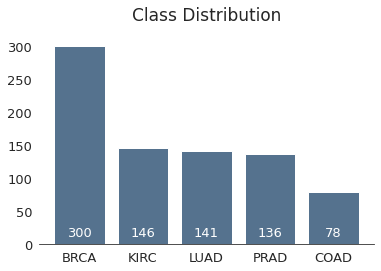

In [11]:
data = y['Class'].value_counts()
hist = pd.Series(data)
classes = [le.classes_[i] for i in hist.index]
model_names = [c+'_ae' for c in classes]
num_classes = len(classes)
count_label = [data[i] for i in hist.index]

n = [i for i in range(num_classes)]
plt.bar(range(len(hist)), hist.values, align='center', color='#55728E')
for i in range(len(count_label)):
  plt.annotate(str(count_label[i]), xy=(n[i], 7),
               ha='center', va='bottom', c='w', fontsize=13)
plt.xticks(range(len(hist)), classes, fontsize=13)
plt.yticks(fontsize=13)
plt.title('Class Distribution', fontsize=17)
plt.ylim(0, max(count_label)+max(count_label)/10)
sns.despine(left=True)
plt.show()

#### `preprocessing`

In [12]:
# deleting the genes which is 0 throughout the column i.e., min=max=0
X, _ = drop_cols_minmax(X)

> input shape :: (801, 20531)
> deleting columns with no impact (min==max) ... ['gene_5', 'gene_23', 'gene_4370', 'gene_4808', 'gene_4809', 'gene_4814', 'gene_4816', 'gene_4817', 'gene_4831', 'gene_5288', 'gene_7661', 'gene_7662', 'gene_7663', 'gene_7664', 'gene_7665', 'gene_8121', 'gene_9304', 'gene_9306', 'gene_9314', 'gene_9316', 'gene_9320', 'gene_9452', 'gene_10121', 'gene_11958', 'gene_13991', 'gene_14158', 'gene_14159', 'gene_14161', 'gene_15138', 'gene_15140', 'gene_15141', 'gene_15446', 'gene_16566', 'gene_16568', 'gene_16569', 'gene_16571', 'gene_16575', 'gene_16578', 'gene_16579', 'gene_16604', 'gene_16634', 'gene_16637', 'gene_16677', 'gene_16697', 'gene_16698', 'gene_16699', 'gene_16700', 'gene_16701', 'gene_16702', 'gene_16704', 'gene_16705', 'gene_16706', 'gene_16707', 'gene_16708', 'gene_16709', 'gene_16710', 'gene_16711', 'gene_16712', 'gene_16713', 'gene_16714', 'gene_16715', 'gene_16716', 'gene_16717', 'gene_16718', 'gene_16719', 'gene_16720', 'gene_16721', 'gene_167

#### `training autoencoder`

In [13]:
folds = 10
skf = StratifiedKFold(n_splits=folds)
skf.get_n_splits(X, y)
print(skf)

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


In [14]:
IO_DIM = X.shape[1]
def Model(summary=True):
    model = Sequential()
    # 20264 > 250 > 21 > 250 > 20264
    model.add(Dense(250, input_dim=IO_DIM, activation='relu'))
    model.add(Dense(21, activation='relu'))
    model.add(Dense(250, activation='relu'))
    model.add(Dense(IO_DIM))
    model.compile(loss='mean_squared_error', optimizer='adam')
    if summary: model.summary()
    return model

early_stopping = EarlyStopping(monitor = 'val_loss', min_delta=0, patience=5, verbose=0, restore_best_weights=True)

In [15]:
def evaluate(model, X_class):
    loss = []
    for x in X_class:
        loss.append(np.sqrt(metrics.mean_squared_error(model.predict(x), x)))
    return loss

def get_pred(df_test, models):
    y_pred = []
    for i in range(len(df_test)):
        loss = []
        x = df_test[i].reshape(1, IO_DIM)
        for model in models:
            loss.append(np.sqrt(metrics.mean_squared_error(model.predict(x), x)))
        loss_idx = loss.index(min(loss))
        y_pred.append(hist.index.values[loss_idx])
    return y_pred

def print_list(lst):
    return [round(i, 4) for i in list(lst)]

def report_model_performance(mat):
    TP = np.diag(mat)
    FP = mat.sum(axis=0) - TP
    FN = mat.sum(axis=1) - TP
    TN = mat.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # F-1 score
    F1S = (2*PPV*TPR)/(PPV+TPR)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Classwise accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)

    measures = {}
    measures['TP'] = TP
    measures['TN'] = TN
    measures['FP'] = FP
    measures['FN'] = FN
    measures['Confusion Matrix'] = mat
    measures['Sensitivity / hit rate / recall / true positive rate'] = print_list(TPR)
    measures['Specificity / true negative rate'] = print_list(TNR)
    measures['Precision / positive predictive value'] = print_list(PPV)
    measures['Negative predictive value'] = print_list(NPV)
    measures['F-1 score'] = print_list(F1S)
    measures['False positive rate'] = print_list(FPR)
    measures['False negative rate'] = print_list(FNR)
    measures['False discovery rate'] = print_list(FDR)
    measures['Classwise Accuracy'] = print_list(ACC)
    measures['Overall Accuracy'] = print_list([accuracy_score(y_test, y_pred)])   

    return measures

def print_measures(measures):
    for c in classes:
        print(c, end='\t')
    print('\n--------------------------------------')
    for k in measures:
        if k == 'Overall Accuracy':
            print('\n'+k, '::', measures[k][0])
        elif k == 'Confusion Matrix':
            continue
        else:
            s = ''
            for m in measures[k]:
                s += str(m) + '\t'
            print(s, '::' , k)

In [16]:
y_test_list = []
y_pred_list = []
all_measures = []
no_of_run = 1       # training takes around 6 mins for each run
i = 0
while i < no_of_run:
    performance_measures = []
    k = 0
    for train_index, test_index in skf.split(X, y):
        print(f'> Go :: {i+1} | Fold :: {k+1}')
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        masks = []
        for c in hist.index.values:
            mask = y['Class'] == c
            masks.append(mask)

        X_all_class = [X_train[mask] for mask in masks]

        X_class = []
        for df in X_all_class:
            X_class.append(df.values)

        X_test = X_test.values
        y_train = y_train.values.flatten()
        y_test = y_test.values.flatten()

        histories = []
        losses = []
        models = []
        for x in X_class:
            x_train, x_test = train_test_split(x, test_size=0.25, random_state=21)
            autoencoder = Model(summary=False)
            histories.append(autoencoder.fit(x_train, x_train,
                                             validation_data=(x_test, x_test),
                                             verbose=0, epochs=500,
                                             callbacks=[early_stopping]))
            losses.append(evaluate(autoencoder, X_class))
            models.append(autoencoder)

        y_pred = get_pred(X_test, models)
        y_test_list.append(y_test)
        y_pred_list.append(y_pred)
        mat = confusion_matrix(y_test, y_pred)
        print('Confusion Matrix')
        print('--------------------------------------')
        print(mat, '\n\n')
        measures = report_model_performance(mat)
        if measures['Overall Accuracy'][0] == 1.0:
            saved_model = models
            print(f"\nmodels saved @ accuracy {measures['Overall Accuracy'][0]}\n")
        print_measures(measures)
        performance_measures.append(measures)
        k += 1
        print('=================================================================================\n')
    all_measures.append(performance_measures)
    i += 1

> Go :: 1 | Fold :: 1
Confusion Matrix
--------------------------------------
[[30  0  0  0  0]
 [ 0  8  0  0  0]
 [ 1  0 14  0  0]
 [ 0  0  0 14  0]
 [ 0  0  0  0 14]] 


BRCA	KIRC	LUAD	PRAD	COAD	
--------------------------------------
30.0	8.0	14.0	14.0	14.0	 :: TP
50.0	73.0	66.0	67.0	67.0	 :: TN
1.0	0.0	0.0	0.0	0.0	 :: FP
0.0	0.0	1.0	0.0	0.0	 :: FN
1.0	1.0	0.9333	1.0	1.0	 :: Sensitivity / hit rate / recall / true positive rate
0.9804	1.0	1.0	1.0	1.0	 :: Specificity / true negative rate
0.9677	1.0	1.0	1.0	1.0	 :: Precision / positive predictive value
1.0	1.0	0.9851	1.0	1.0	 :: Negative predictive value
0.9836	1.0	0.9655	1.0	1.0	 :: F-1 score
0.0196	0.0	0.0	0.0	0.0	 :: False positive rate
0.0	0.0	0.0667	0.0	0.0	 :: False negative rate
0.0323	0.0	0.0	0.0	0.0	 :: False discovery rate
0.9877	1.0	0.9877	1.0	1.0	 :: Classwise Accuracy

Overall Accuracy :: 0.9877

> Go :: 1 | Fold :: 2
Confusion Matrix
--------------------------------------
[[30  0  0  0  0]
 [ 0  7  0  0  0]
 [ 0  0 15  0 

#### `saving the trained autoencoders for further dissection`

In [17]:
!mkdir autoencoders

In [18]:
for idx, model in enumerate(saved_model):
    model.save(f'autoencoders/{model_names[idx]}.h5')

In [19]:
!zip -r autoencoders.zip autoencoders/*h5

  adding: autoencoders/BRCA_ae.h5 (deflated 17%)
  adding: autoencoders/COAD_ae.h5 (deflated 23%)
  adding: autoencoders/KIRC_ae.h5 (deflated 19%)
  adding: autoencoders/LUAD_ae.h5 (deflated 19%)
  adding: autoencoders/PRAD_ae.h5 (deflated 22%)


### `section 2 - reversing the learning mechanism`

> please execute section 0 first and then proceed to execue the following section.

#### `loading and preprocessing dataset`

In [20]:
X, y = read_dataset('dataset')

reading data... finished with shape: (801, 20531) and type <class 'pandas.core.frame.DataFrame'>.
reading labels... finished with shape: (801, 1) and type <class 'pandas.core.frame.DataFrame'>.


In [21]:
le = LabelEncoder()
num_label = le.fit_transform(y.values)
y['Class'] = num_label

data = y['Class'].value_counts()
hist = pd.Series(data)
classes = [le.classes_[i] for i in hist.index]
classes

['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD']

In [22]:
# deleting the genes which is 0 throughout the column i.e., min=max=0
X, deleted_genes = drop_cols_minmax(X)
gene_names = np.asarray(X.columns)

> input shape :: (801, 20531)
> deleting columns with no impact (min==max) ... ['gene_5', 'gene_23', 'gene_4370', 'gene_4808', 'gene_4809', 'gene_4814', 'gene_4816', 'gene_4817', 'gene_4831', 'gene_5288', 'gene_7661', 'gene_7662', 'gene_7663', 'gene_7664', 'gene_7665', 'gene_8121', 'gene_9304', 'gene_9306', 'gene_9314', 'gene_9316', 'gene_9320', 'gene_9452', 'gene_10121', 'gene_11958', 'gene_13991', 'gene_14158', 'gene_14159', 'gene_14161', 'gene_15138', 'gene_15140', 'gene_15141', 'gene_15446', 'gene_16566', 'gene_16568', 'gene_16569', 'gene_16571', 'gene_16575', 'gene_16578', 'gene_16579', 'gene_16604', 'gene_16634', 'gene_16637', 'gene_16677', 'gene_16697', 'gene_16698', 'gene_16699', 'gene_16700', 'gene_16701', 'gene_16702', 'gene_16704', 'gene_16705', 'gene_16706', 'gene_16707', 'gene_16708', 'gene_16709', 'gene_16710', 'gene_16711', 'gene_16712', 'gene_16713', 'gene_16714', 'gene_16715', 'gene_16716', 'gene_16717', 'gene_16718', 'gene_16719', 'gene_16720', 'gene_16721', 'gene_167

#### `downloading the trained autoencoders`


In [24]:
# to reproduce the results: delete the newly trained autoencoders 
!rm -rf autoencoders*

# and download the previously trained autoencoders
!gdown --id 1-HAwBU1FESQkgGP-IUnNkrZLWCTGgXI7

!unzip autoencoders.zip
!rm autoencoders.zip

Downloading...
From: https://drive.google.com/uc?id=1-HAwBU1FESQkgGP-IUnNkrZLWCTGgXI7
To: /content/autoencoders.zip
480MB [00:02, 166MB/s]
Archive:  autoencoders.zip
   creating: autoencoders/
  inflating: autoencoders/LUAD_ae.h5  
  inflating: autoencoders/KIRC_ae.h5  
  inflating: autoencoders/COAD_ae.h5  
  inflating: autoencoders/PRAD_ae.h5  
  inflating: autoencoders/BRCA_ae.h5  


#### `loading models`

In [25]:
IO_DIM = 20264
model_names = [c + '_ae' for c in classes]

models = []
for model in model_names:
    ae = load_model(f"autoencoders/{model}.h5")
    print(model, type(ae))
    models.append(ae)

BRCA_ae <class 'keras.engine.sequential.Sequential'>
KIRC_ae <class 'keras.engine.sequential.Sequential'>
LUAD_ae <class 'keras.engine.sequential.Sequential'>
PRAD_ae <class 'keras.engine.sequential.Sequential'>
COAD_ae <class 'keras.engine.sequential.Sequential'>


#### `dissecting the models`

splitting the data with respect to their classes.

In [26]:
BRCA_df = X[y['type']=='BRCA']
KIRC_df = X[y['type']=='KIRC']
LUAD_df = X[y['type']=='LUAD']
PRAD_df = X[y['type']=='PRAD']
COAD_df = X[y['type']=='COAD']

BRCA_df.reset_index(drop=True, inplace=True)
KIRC_df.reset_index(drop=True, inplace=True)
LUAD_df.reset_index(drop=True, inplace=True)
PRAD_df.reset_index(drop=True, inplace=True)
COAD_df.reset_index(drop=True, inplace=True)

brca_values = BRCA_df.values
kirc_values = KIRC_df.values
luad_values = LUAD_df.values
prad_values = PRAD_df.values
coad_values = COAD_df.values

all_values = [brca_values, kirc_values, luad_values, prad_values, coad_values]

getting the encoded representation from the trained models passing all the instances of data for each class to it's corresponding autoencoder

In [27]:
def get_encoded_values(idx, get_raw=False, level=1):
    model = models[idx]
    class_values = all_values[idx]
    encoded_values = []
    for value_idx, value in enumerate(class_values):
        x = value.reshape(1, IO_DIM)
        for layerIndex, layer in enumerate(model.layers):
            func = K.function([model.get_layer(index=0).input], layer.output)
            layerOutput = func([x])  # input_data is a numpy array
            if layerIndex == level:
                if get_raw:
                    encoded_values.append(value)
                else:
                    encoded_values.append(layerOutput[0])
    print('>', classes[idx], len(encoded_values))
    return np.array(encoded_values)

level represents the layer of the autoencoder
*   don't care for raw input [20264], get_raw should be True
*   0 for middle layer [250], get_raw should be False
*   1 for the bottleneck layer [21], get_raw should be False

In [28]:
print('for raw input [20264]')
encoded_brca_raw = get_encoded_values(0, get_raw=True)
encoded_kirc_raw = get_encoded_values(1, get_raw=True)
encoded_luad_raw = get_encoded_values(2, get_raw=True)
encoded_prad_raw = get_encoded_values(3, get_raw=True)
encoded_coad_raw = get_encoded_values(4, get_raw=True)
print()

print('for intermediate layer [250]')
level = 0
encoded_brca_250 = get_encoded_values(0, level=level)
encoded_kirc_250 = get_encoded_values(1, level=level)
encoded_luad_250 = get_encoded_values(2, level=level)
encoded_prad_250 = get_encoded_values(3, level=level)
encoded_coad_250 = get_encoded_values(4, level=level)
print()

print('for bottleneck layer [21]')
level = 1
encoded_brca_21 = get_encoded_values(0, level=level)
encoded_kirc_21 = get_encoded_values(1, level=level)
encoded_luad_21 = get_encoded_values(2, level=level)
encoded_prad_21 = get_encoded_values(3, level=level)
encoded_coad_21 = get_encoded_values(4, level=level)

for raw input [20264]
> BRCA 300
> KIRC 146
> LUAD 141
> PRAD 136
> COAD 78

for intermediate layer [250]
> BRCA 300
> KIRC 146
> LUAD 141
> PRAD 136
> COAD 78

for bottleneck layer [21]
> BRCA 300
> KIRC 146
> LUAD 141
> PRAD 136
> COAD 78


#### `plotting internal representation as heatmap`

In [29]:
# courtesy: https://stackoverflow.com/a/55033412

def hex2rgb(hex):
    """hex (string) to rgb (tuple3)"""
    hex_cleaned = hex.lstrip('#')
    return tuple(int(hex_cleaned[i:i+2], 16) for i in (0, 2 ,4))

def rgb2hex(rgb):
    """rgb (tuple3) to hex (string)"""
    return '#' + ''.join([str('0' + hex(hh)[2:])[-2:] for hh in rgb])

def color_mixer(hex1, hex2, wt1=0.5):
    """weighted mix of two colors in RGB space (takes and returns hex values)"""
    rgb1 = hex2rgb(hex1)
    rgb2 = hex2rgb(hex2)
    return rgb2hex(tuple([int(wt1 * tup[0] + (1.0 - wt1) * tup[1]) for tup in zip(rgb1, rgb2)]))

def create_palette(start_color, mid_color, end_color, num_colors):
    """create full palette"""
    num_steps = num_colors  
    steps = np.linspace(0, 1, num_steps)[::-1]
    pt1 = [color_mixer(start_color, mid_color, wt) for wt in steps]
    pt2 = [color_mixer(mid_color,  end_color, wt) for wt in steps[1:]]
    return (pt1 + pt2)[::2]

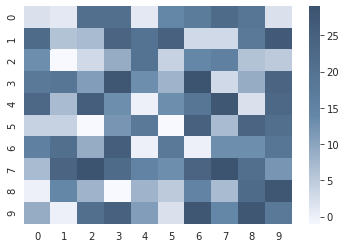

In [30]:
first_color = '#f8f8ff'   # off-white
last_color  = '#6587A8'   # base-blue
dark_base_color = '#152238'

mid_color   = color_mixer(first_color, last_color)
mid2_color  = color_mixer(mid_color, last_color)
mid3_color  = color_mixer(last_color, dark_base_color)

custom_colors = create_palette(first_color, last_color, mid3_color, 30000) # '#23595d' '#1c2e4a'  '#152238'

data = np.random.randint(-1, 30, (10,10)) # Random [-1, 0, 1] data
sns.heatmap(data, cmap=ListedColormap(custom_colors))
plt.show()

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


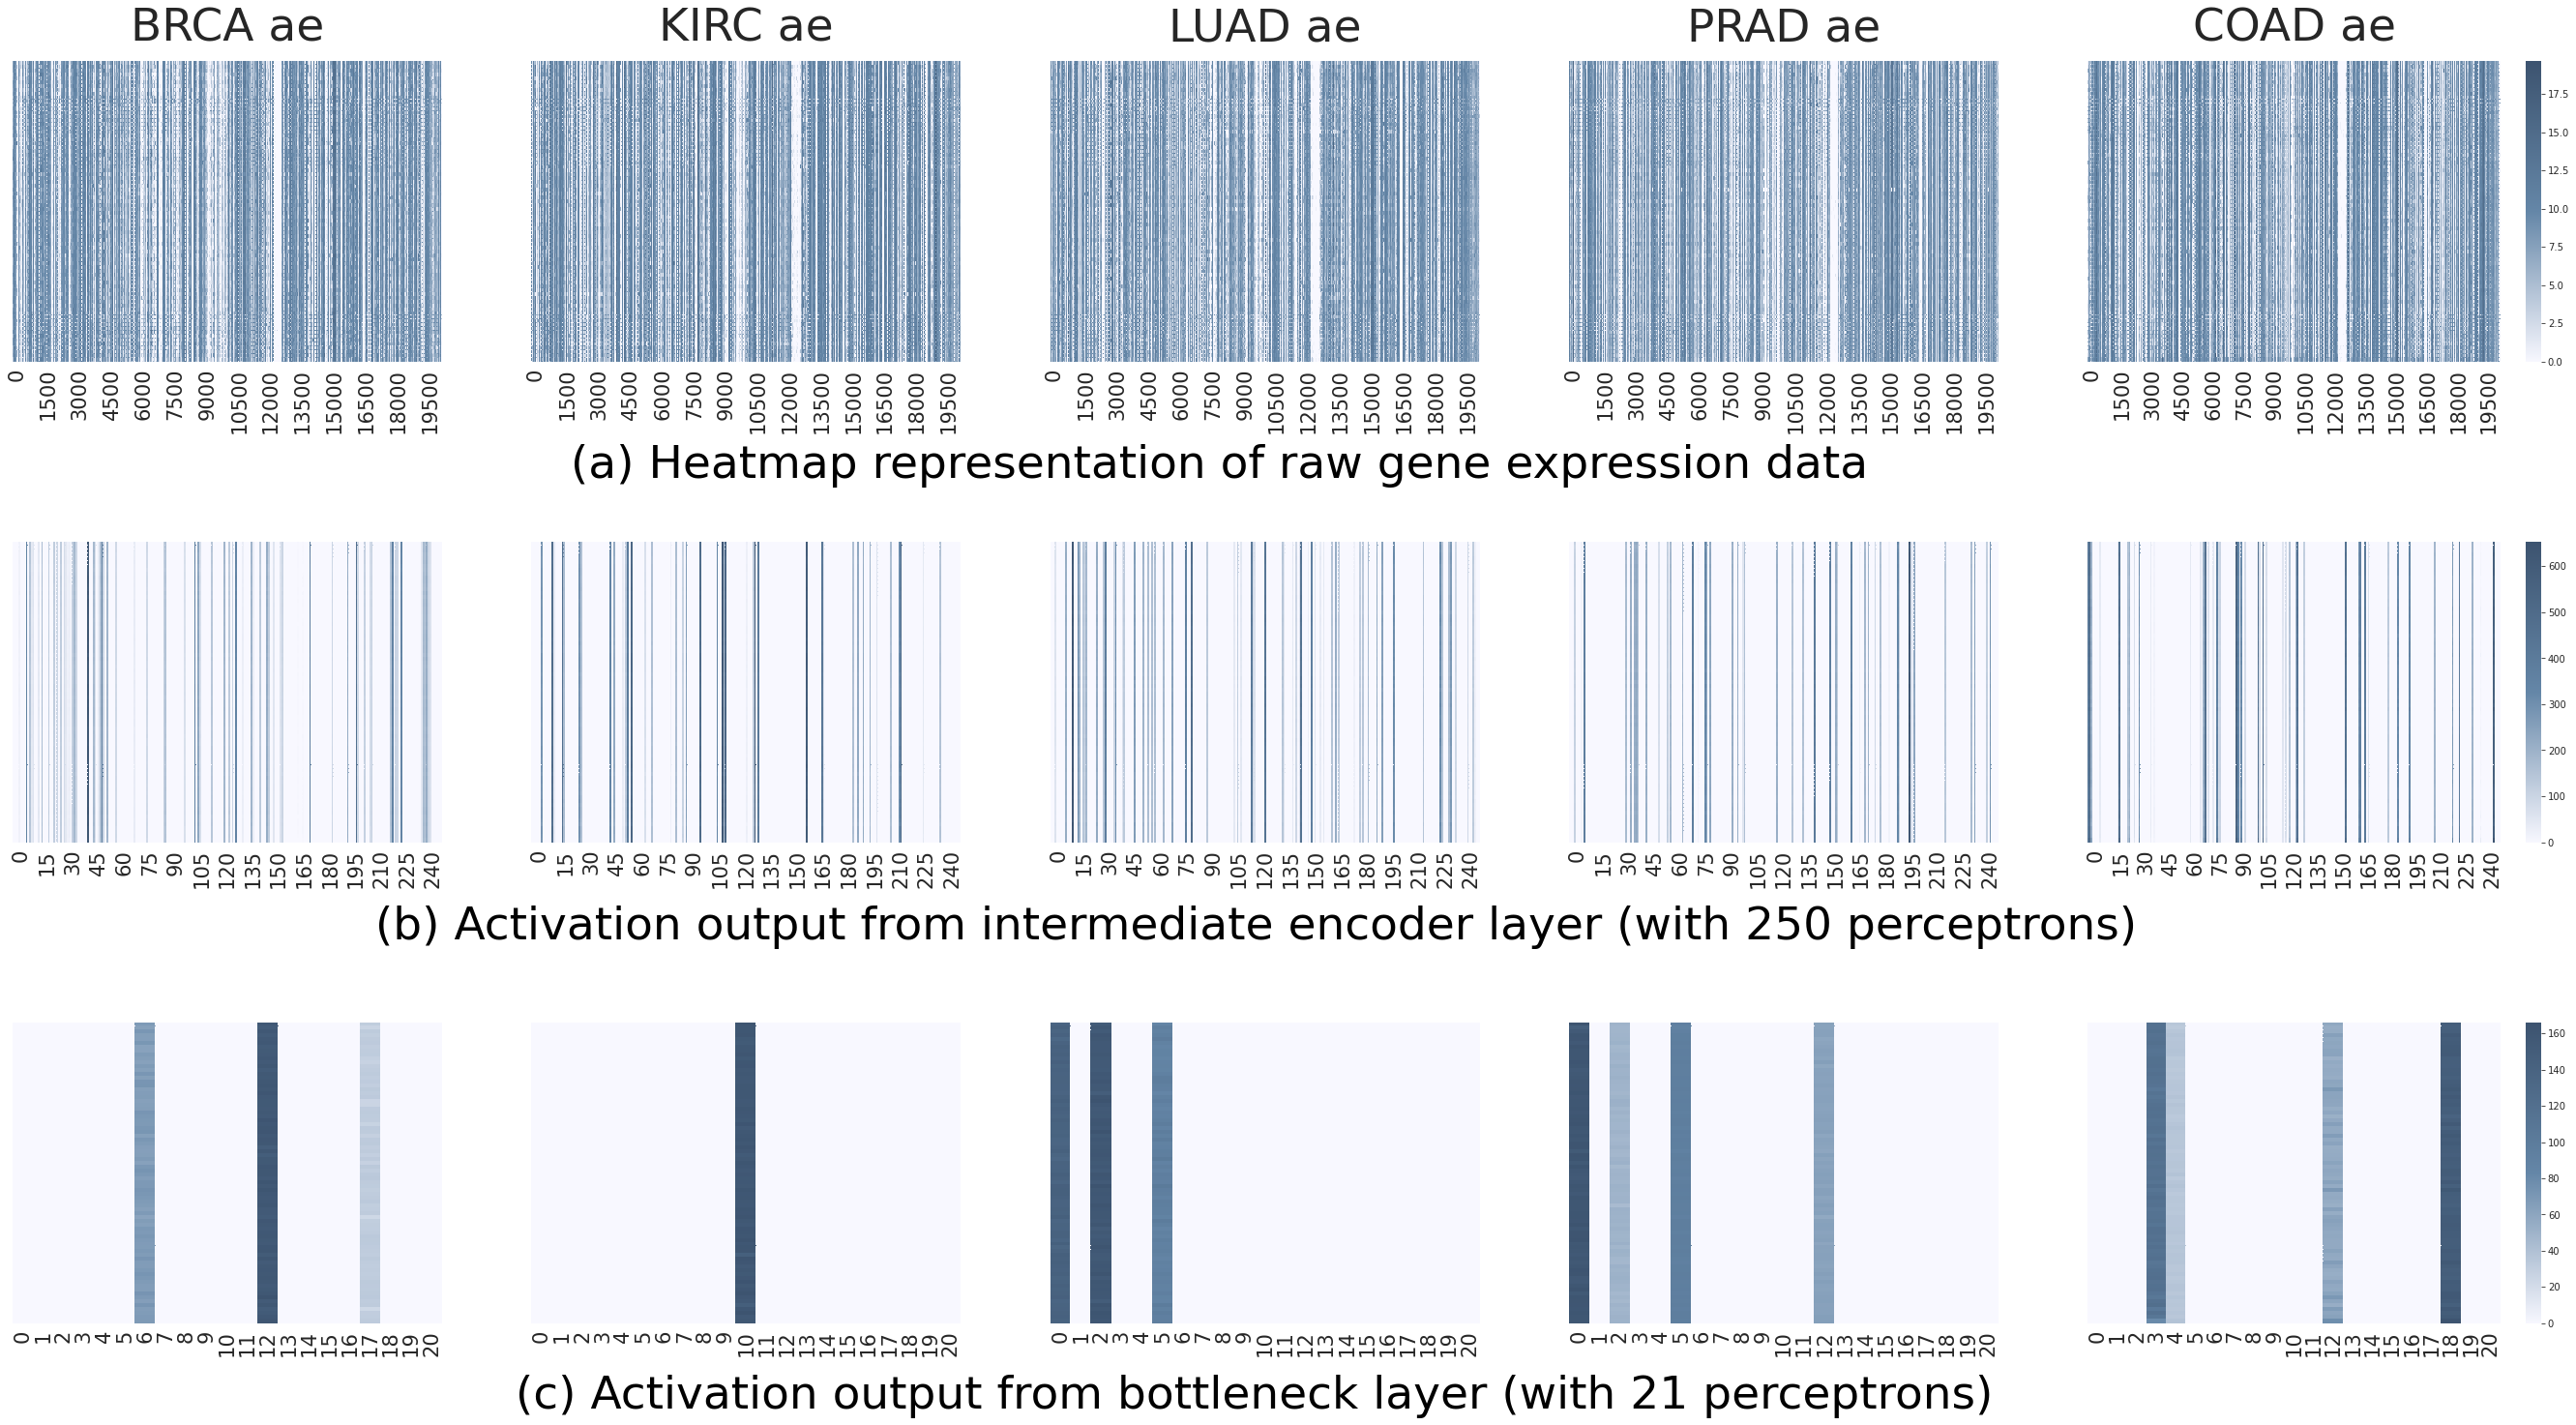

In [31]:
# it takes around 2 mins to plot the heatmap
limit = min(hist)
FACTOR = 1
fig, axs = plt.subplots(3, 5, figsize=(48*FACTOR, 24*FACTOR), gridspec_kw={'width_ratios':[1, 1, 1, 1, 1.2]})

color_map = ListedColormap(custom_colors)
color_bar = False
ae_title_fontsize = 47*FACTOR
X_TICKS_FONT_SIZE = 21*FACTOR
ticks_font = font_manager.FontProperties(family='Times New Roman', size=X_TICKS_FONT_SIZE, style='normal', weight='normal', stretch='normal')
csfont = {'fontname':'Times New Roman'}

g1 = sns.heatmap(encoded_brca_raw[:limit], cmap=color_map, cbar=color_bar, ax=axs[0][0])
g2 = sns.heatmap(encoded_kirc_raw[:limit], cmap=color_map, cbar=color_bar, ax=axs[0][1])
g3 = sns.heatmap(encoded_luad_raw[:limit], cmap=color_map, cbar=color_bar, ax=axs[0][2])
g4 = sns.heatmap(encoded_prad_raw[:limit], cmap=color_map, cbar=color_bar, ax=axs[0][3])
g5 = sns.heatmap(encoded_coad_raw[:limit], cmap=color_map, cbar=True, ax=axs[0][4])

p = 21
g1.set_title(f'{classes[0]} ae', fontsize=ae_title_fontsize, pad=p, **csfont)
g2.set_title(f'{classes[1]} ae', fontsize=ae_title_fontsize, pad=p, **csfont)
g3.set_title(f'{classes[2]} ae', fontsize=ae_title_fontsize, pad=p, **csfont)
g4.set_title(f'{classes[3]} ae', fontsize=ae_title_fontsize, pad=p, **csfont)
g5.set_title(f'{classes[4]} ae', fontsize=ae_title_fontsize, pad=p, **csfont)

g6 = sns.heatmap(encoded_brca_250[:limit], cmap=color_map, cbar=color_bar, ax=axs[1][0])
g7 = sns.heatmap(encoded_kirc_250[:limit], cmap=color_map, cbar=color_bar, ax=axs[1][1])
g8 = sns.heatmap(encoded_luad_250[:limit], cmap=color_map, cbar=color_bar, ax=axs[1][2])
g9 = sns.heatmap(encoded_prad_250[:limit], cmap=color_map, cbar=color_bar, ax=axs[1][3])
g10 = sns.heatmap(encoded_coad_250[:limit], cmap=color_map, cbar=True, ax=axs[1][4])

g11 = sns.heatmap(encoded_brca_21[:limit], cmap=color_map, cbar=color_bar, ax=axs[2][0])
g12 = sns.heatmap(encoded_kirc_21[:limit], cmap=color_map, cbar=color_bar, ax=axs[2][1])
g13 = sns.heatmap(encoded_luad_21[:limit], cmap=color_map, cbar=color_bar, ax=axs[2][2])
g14 = sns.heatmap(encoded_prad_21[:limit], cmap=color_map, cbar=color_bar, ax=axs[2][3])
g15 = sns.heatmap(encoded_coad_21[:limit], cmap=color_map, cbar=True, ax=axs[2][4])

g3.text(8000, 105, '(a) Heatmap representation of raw gene expression data', color='black',
        fontsize=ae_title_fontsize, verticalalignment='center',
        horizontalalignment='center', **csfont)
g8.text(120, 100, '(b) Activation output from intermediate encoder layer (with 250 perceptrons)', color='black',
        fontsize=ae_title_fontsize, verticalalignment='center',
        horizontalalignment='center', **csfont)
g13.text(10, 97, '(c) Activation output from bottleneck layer (with 21 perceptrons)', color='black',
        fontsize=ae_title_fontsize, verticalalignment='center',
        horizontalalignment='center', **csfont)

for idx, g in enumerate([g1, g2, g3, g4, g5, g6, g7, g8, g9, g10]):
    if idx < 5:
        arr = np.arange(0, 20264+1, 1500)
        rot = 90
    elif idx < 10:
        arr = np.arange(0, 250+1, 15)
        rot = 90
    g.set_xticklabels(arr, fontsize=X_TICKS_FONT_SIZE, **csfont, rotation=rot)
    if idx < 5:
        arr = arr+200
    elif idx < 10:
        arr = arr+5
    g.set_xticks(arr)
    g.set_ylabel('')
    g.set_xlabel('')
    g.set_yticks([])
    for label in g.get_xticklabels():
        label.set_fontproperties(ticks_font)

for idx, g in enumerate([g11, g12, g13, g14, g15]):
    g.set_ylabel('')
    g.set_xlabel('')
    g.set_yticks([])
    g.set_xticklabels(np.arange(0, 22, 1), fontsize=X_TICKS_FONT_SIZE, **csfont, rotation=90)
    for label in g.get_xticklabels():
        label.set_fontproperties(ticks_font)

fig.subplots_adjust(hspace=0.6)
plt.savefig(f'heatmap.png', bbox_inches='tight', pad_inches=0)
plt.show()

#### `from activated perceptrons to influence filtering`

ignoring the bias from the input, we measured the influences percentage of the inputs and sorted them in reversed order. then we filtered the genes by weight percentage of reversed sorted idx list.

In [32]:
def relu(x):
    """rectified linear unit (activation function)"""
    return max(0, x)

# unit test
relu(-3), relu(0.1), relu(3)

(0, 0.1, 3)

In [33]:
def get_influence(input, output):
    """getting gene influence (%) score and indices list when the inputs are reversely sorted"""
    influence = []
    for i in input:
        influence.append(i/output)
    influence = np.asarray(influence)*100
    rev_sorted_idx = sorted(range(len(influence)), key=lambda k: influence[k], reverse=True)
    return influence, rev_sorted_idx

# unit test
input_list = [30, 10, 20, 27, 21]
inf, idx = get_influence(input_list, sum(input_list))
inf, sum(inf), idx

(array([27.77777778,  9.25925926, 18.51851852, 25.        , 19.44444444]),
 100.0,
 [0, 3, 4, 2, 1])

In [34]:
def get_wighted_influence(relu_output_list, influencial_idx_list):
    all_idx = np.hstack(influencial_idx_list)
    unique, counts = np.unique(all_idx, return_counts=True)
    count_dict = dict(zip(unique, counts))

    relu_output_inf_percentage = relu_output_list/sum(relu_output_list)
    idx_per_list = np.ceil(relu_output_inf_percentage*INF_IDX_LIMIT)
    idx_per_list = np.asarray(idx_per_list, dtype=int)

    reserved_inf_by_percentage = []
    for i in range(len(influencial_idx_list)):
        idx_per_list_limit = idx_per_list[i]    # mostly 1, could be 2
        reserved_inf_by_percentage.extend(influencial_idx_list[i][:idx_per_list_limit])
    all_selected_idx = np.unique(reserved_inf_by_percentage)
    print(f'# total filtered_genes: {len(all_selected_idx)}')
    return np.asarray(all_selected_idx)

def get_all_influencers_gene_names(gene_names, all_influencers_idx):
    influencer_gene_names = []
    for i in all_influencers_idx:
        influencer_gene_names.append(gene_names[int(i)])
    return np.asarray(influencer_gene_names)

iterative development of the method: one step at a time observing with minimal data. some of the following code blocks are optional and for demonstration purpose only. you may want to jump at [the filtration method as a whole](#scrollTo=PbfdSq5Hdtxq&line=1&uniqifier=1).

In [35]:
# select model and data
model = models[0]
data = all_values[0]
len(data)

300

In [36]:
layer_weights = model.get_weights()
len(models), len(layer_weights)

(5, 8)

In [37]:
for l in layer_weights:
    print(l.shape)

(20264, 250)
(250,)
(250, 21)
(21,)
(21, 250)
(250,)
(250, 20264)
(20264,)


first, we investigate the biases.

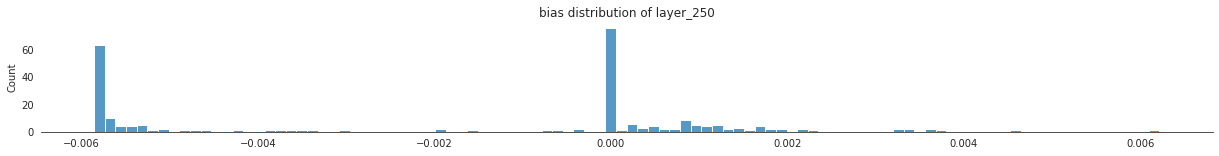

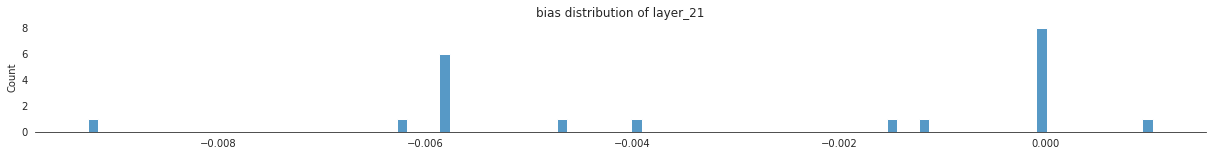

In [38]:
plt.figure(figsize=(21, 2))
sns.histplot(layer_weights[1], bins=100)
sns.despine(left=True)
plt.title('bias distribution of layer_250')
plt.show()

plt.figure(figsize=(21, 2))
sns.histplot(layer_weights[3], bins=100)
sns.despine(left=True)
plt.title('bias distribution of layer_21')
plt.show()

as the biases are very negligible to the inputs and weights, we ignored them for simplicity of calculation.

In [39]:
print('Activated Perceptrons for layer_250')
print('======================================================================\n')
# number of inputs :: 300 for brca
# observing first 3
for j in range(3):
    print(f'propagating expressions no.: {j+1}\n\tactivated perceptron (activation):', end=' ')
    total_activated_neurons = []
    for i in range(250):
        input_x_weight = layer_weights[0][:, i] * data[j]
        neural_output = sum(input_x_weight) + layer_weights[1][i]
        if relu(neural_output):
            _, influence_idx = get_influence(input_x_weight, relu(neural_output))
            print(f'{i} ({relu(neural_output):.4f})\t', end=' ')
            total_activated_neurons.append(i)
    print()
    print(f'\t# activated perceptrons: {len(total_activated_neurons)}\n')

Activated Perceptrons for layer_250

propagating expressions no.: 1
	activated perceptron (activation): 4 (22.6766)	 8 (461.3347)	 10 (189.3321)	 11 (53.4078)	 12 (75.5371)	 15 (58.9924)	 17 (223.8961)	 21 (157.2149)	 24 (160.7518)	 26 (127.7284)	 28 (164.6639)	 30 (109.8185)	 31 (61.4082)	 32 (28.9951)	 33 (32.9639)	 35 (155.8476)	 36 (241.9584)	 37 (122.7493)	 44 (824.2230)	 47 (236.1476)	 48 (90.7927)	 50 (47.5051)	 51 (211.8263)	 52 (492.2260)	 53 (127.4587)	 55 (251.6502)	 60 (118.4670)	 71 (43.7416)	 78 (115.2281)	 88 (142.9033)	 89 (196.7392)	 100 (95.0200)	 106 (483.3316)	 108 (305.8379)	 109 (97.2086)	 116 (187.7763)	 123 (252.2305)	 126 (166.3677)	 128 (130.2348)	 130 (456.9023)	 134 (37.8234)	 139 (257.2409)	 140 (37.2042)	 144 (172.1128)	 148 (283.5182)	 149 (160.2420)	 152 (69.9756)	 156 (75.7669)	 157 (130.5000)	 166 (2.7765)	 169 (1.3916)	 173 (502.4756)	 186 (130.9507)	 195 (291.7540)	 200 (613.9158)	 201 (113.9740)	 205 (148.0039)	 208 (107.3515)	 209 (142.0555)	 220 (

here, we can see that the activated perceptrons are very same for all the inputs. also see the heatmap representation of the activated perceptrons. the straight lines for the perceptrons also represents that.

In [40]:
# printing most activated perceptrons of layer_21 with their activation and influences from layer_250
INF_IDX_LIMIT = 21
print(f'Activated Perceptrons for layer_21')
print('=========================================================\n')
for j in range(3):
    print(f'propagating expressions no.: {j+1}\n\t', end='')
    relu_output_list = []
    influencial_idx_list = []
    secend_layer_input = []
    for i in range(250):
        input_x_weight = layer_weights[0][:, i] * data[j]
        neural_output = sum(input_x_weight) + layer_weights[1][i]
        secend_layer_input.append(relu(neural_output))
    secend_layer_input = np.asarray(secend_layer_input)
    for i in range(21):
        input_x_weight = layer_weights[2][:, i] * secend_layer_input
        neural_output = sum(input_x_weight) + layer_weights[3][i]
        if relu(neural_output):
            _, influence_idx = get_influence(input_x_weight, relu(neural_output))
            relu_output_list.append(relu(neural_output))
            influencial_idx_list.append(influence_idx[:INF_IDX_LIMIT])
            print(f'perceptron: {i}\tactivation: {relu(neural_output)}\tinfluencers (top {INF_IDX_LIMIT}): {influence_idx[:INF_IDX_LIMIT]}\n\t', end='')
    relu_output_list = np.asarray(relu_output_list)
    influencial_idx_list = np.asarray(influencial_idx_list)
    print('---------------------------------------------------------------\n\t', end='')
    all_influencers = get_wighted_influence(relu_output_list, influencial_idx_list)
    print(f'\tall_influencers: {list(all_influencers)}')
    print()

Activated Perceptrons for layer_21

propagating expressions no.: 1
	perceptron: 6	activation: 79.23113693517884	influencers (top 21): [200, 173, 106, 47, 116, 108, 130, 28, 60, 88, 157, 205, 126, 52, 144, 139, 37, 10, 17, 123, 35]
	perceptron: 12	activation: 183.41505598380238	influencers (top 21): [139, 44, 241, 195, 28, 17, 88, 148, 108, 224, 128, 36, 157, 10, 26, 37, 30, 220, 242, 208, 201]
	perceptron: 17	activation: 36.51213757618896	influencers (top 21): [44, 106, 52, 195, 47, 10, 226, 21, 8, 240, 28, 200, 30, 89, 37, 201, 126, 139, 100, 208, 51]
	---------------------------------------------------------------
	# total filtered_genes: 19
	all_influencers: [17, 28, 36, 44, 47, 52, 88, 106, 108, 116, 128, 139, 148, 157, 173, 195, 200, 224, 241]

propagating expressions no.: 2
	perceptron: 6	activation: 74.09098889119049	influencers (top 21): [200, 173, 106, 47, 116, 108, 130, 28, 88, 60, 157, 205, 126, 144, 52, 139, 37, 10, 17, 123, 35]
	perceptron: 12	activation: 176.5109465392471

from the heatmap, we can also see that the activated perceptrons are always 6, 12 and 17 for BRCA in the bottleneck layer.

In [41]:
!mkdir filtered_genes genes_counts

In [42]:
def count_and_sort_genes(genes):
    unique, counts = np.unique(genes, return_counts=True)
    count_dict = dict(zip(unique, counts))
    genes_counts = sorted(count_dict.items(), key=lambda x:x[1], reverse=True)
    return genes_counts

now, we will run the filtration method as a whole for all the classes. this cell may take ~30 minuites depending on the machine.

In [43]:
for class_idx in range(5):
    # select model and data
    model = models[class_idx]
    data = all_values[class_idx]
    data_class = classes[class_idx]

    gene_names_from_all_input = []
    INF_IDX_LIMIT = 21
    # printing most activated perceptrons of layer_250 with their activation and influences from layer_20K
    print(f'\n[{class_idx+1}/{len(classes)}] filtering for {data_class}')
    print('=========================================================')
    for j in range(data.shape[0]):
        relu_output_list = []
        influencial_idx_list = []
        secend_layer_input = []
        for i in range(250):
            input_x_weight = layer_weights[0][:, i] * data[j]
            neural_output = sum(input_x_weight) + layer_weights[1][i]
            if relu(neural_output):
                _, influence_idx = get_influence(input_x_weight, relu(neural_output))
                relu_output_list.append(relu(neural_output))
                influencial_idx_list.append(influence_idx[:INF_IDX_LIMIT])
                # print(f'perceptron: {i}\tactivation: {relu(neural_output)}\tinfluences ({INF_IDX_LIMIT}): {influence_idx[:INF_IDX_LIMIT]}')
        relu_output_list = np.asarray(relu_output_list)
        influencial_idx_list = np.asarray(influencial_idx_list)

        # print formatting (not important at all!)
        if j < 9: p = '00'
        elif j < 99: p = '0'
        else: p = ''
        if data_class == 'COAD':
            if j < 9: p = '0'
            else: p = ''
        print(f'> [{p}{j+1}/{data.shape[0]}]', end='\t')

        all_influencers_idx = get_wighted_influence(relu_output_list, influencial_idx_list)
        influencer_gene_names = get_all_influencers_gene_names(gene_names, all_influencers_idx)
        # print(f'len(all_influencers_idx): {len(all_influencers_idx)} | {len(influencer_gene_names)} | all_influencers: {all_influencers_idx} | influencer_gene_names: {influencer_gene_names}')
        gene_names_from_all_input.append(influencer_gene_names)
        
    # saving the data
    gene_names_from_all_input = np.asarray(gene_names_from_all_input)
    np.save(f'filtered_genes/{data_class}.npy', gene_names_from_all_input)

    gene_list = np.load(f'filtered_genes/{data_class}.npy', allow_pickle=True)
    all_genes = []
    for gene in gene_list:
        all_genes.extend(gene)
    all_genes_counts = count_and_sort_genes(all_genes)
    count_df = pd.DataFrame.from_dict(all_genes_counts)
    count_df.columns = ['gene', 'count']
    count_df.to_csv(f'genes_counts/{data_class}_all_genes_counts.csv', index=False)
    count_df


[1/5] filtering for BRCA
> [001/300]	# total filtered_genes: 36
> [002/300]	# total filtered_genes: 39
> [003/300]	# total filtered_genes: 41
> [004/300]	# total filtered_genes: 39
> [005/300]	# total filtered_genes: 34
> [006/300]	# total filtered_genes: 33
> [007/300]	# total filtered_genes: 32
> [008/300]	# total filtered_genes: 34
> [009/300]	# total filtered_genes: 31
> [010/300]	# total filtered_genes: 40
> [011/300]	# total filtered_genes: 40
> [012/300]	# total filtered_genes: 38
> [013/300]	# total filtered_genes: 34
> [014/300]	# total filtered_genes: 42
> [015/300]	# total filtered_genes: 35
> [016/300]	# total filtered_genes: 40
> [017/300]	# total filtered_genes: 43
> [018/300]	# total filtered_genes: 37
> [019/300]	# total filtered_genes: 35
> [020/300]	# total filtered_genes: 35
> [021/300]	# total filtered_genes: 41
> [022/300]	# total filtered_genes: 41
> [023/300]	# total filtered_genes: 32
> [024/300]	# total filtered_genes: 41
> [025/300]	# total filtered_genes: 32

In [44]:
!zip -qr filtered_genes.zip filtered_genes/*npy
!zip -qr genes_counts.zip genes_counts/*csv

### `section 3 - selecting the biomarker genes`

> please execute section 0 first and then proceed to execue the following section.

#### `downloading filtered genes and counts`

In [1]:
!gdown --id 13bZgngv8U84k9x6Lh7ykRkAlWpfVANtu
!unzip -qq genes_counts.zip
!rm -rf genes_counts.zip

Downloading...
From: https://drive.google.com/uc?id=13bZgngv8U84k9x6Lh7ykRkAlWpfVANtu
To: /content/genes_counts.zip
100% 7.94k/7.94k [00:00<00:00, 6.88MB/s]


In [39]:
brca_df = pd.read_csv('genes_counts/BRCA_all_genes_counts.csv')
kirc_df = pd.read_csv('genes_counts/KIRC_all_genes_counts.csv')
luad_df = pd.read_csv('genes_counts/LUAD_all_genes_counts.csv')
prad_df = pd.read_csv('genes_counts/PRAD_all_genes_counts.csv')
coad_df = pd.read_csv('genes_counts/COAD_all_genes_counts.csv')
dfs = [brca_df, kirc_df, luad_df, prad_df, coad_df]

brca_df.shape, kirc_df.shape, luad_df.shape, prad_df.shape, coad_df.shape

((638, 2), (351, 2), (464, 2), (278, 2), (252, 2))

#### `theory for gene selection`

> Getting the Curve
0.   counts = descending_sort(counts)
1.   cum_counts = cumulative_sum(counts)
2.   normalized_cum_counts = cum_counts/max(cum_counts)
3.   plot(normalized_cum_counts)

In [40]:
data = np.array(brca_df['count'])
data

array([291, 269, 263, 261, 260, 252, 236, 225, 220, 191, 185, 184, 182,
       179, 177, 173, 168, 162, 159, 141, 137, 136, 132, 121, 120, 115,
       112, 106, 105, 104,  99,  99,  94,  92,  91,  87,  86,  80,  79,
        78,  66,  66,  65,  62,  62,  60,  60,  59,  59,  58,  57,  56,
        53,  52,  52,  51,  51,  49,  49,  49,  48,  47,  47,  46,  45,
        44,  44,  43,  42,  42,  41,  40,  39,  37,  36,  36,  36,  35,
        35,  34,  32,  31,  30,  30,  30,  29,  29,  28,  28,  28,  27,
        26,  26,  26,  25,  25,  25,  24,  24,  23,  23,  23,  22,  22,
        21,  21,  21,  21,  21,  20,  20,  20,  20,  20,  19,  19,  19,
        18,  18,  18,  18,  17,  17,  17,  17,  16,  16,  15,  15,  15,
        15,  15,  15,  15,  15,  13,  13,  13,  13,  12,  12,  12,  12,
        12,  12,  12,  12,  12,  12,  12,  12,  11,  11,  11,  11,  11,
        11,  11,  11,  10,  10,  10,  10,  10,  10,  10,  10,   9,   9,
         9,   9,   9,   9,   9,   9,   9,   8,   8,   8,   8,   

In [41]:
cum_count = np.cumsum(data)
cum_count

array([  291,   560,   823,  1084,  1344,  1596,  1832,  2057,  2277,
        2468,  2653,  2837,  3019,  3198,  3375,  3548,  3716,  3878,
        4037,  4178,  4315,  4451,  4583,  4704,  4824,  4939,  5051,
        5157,  5262,  5366,  5465,  5564,  5658,  5750,  5841,  5928,
        6014,  6094,  6173,  6251,  6317,  6383,  6448,  6510,  6572,
        6632,  6692,  6751,  6810,  6868,  6925,  6981,  7034,  7086,
        7138,  7189,  7240,  7289,  7338,  7387,  7435,  7482,  7529,
        7575,  7620,  7664,  7708,  7751,  7793,  7835,  7876,  7916,
        7955,  7992,  8028,  8064,  8100,  8135,  8170,  8204,  8236,
        8267,  8297,  8327,  8357,  8386,  8415,  8443,  8471,  8499,
        8526,  8552,  8578,  8604,  8629,  8654,  8679,  8703,  8727,
        8750,  8773,  8796,  8818,  8840,  8861,  8882,  8903,  8924,
        8945,  8965,  8985,  9005,  9025,  9045,  9064,  9083,  9102,
        9120,  9138,  9156,  9174,  9191,  9208,  9225,  9242,  9258,
        9274,  9289,

In [42]:
nor_cum_count = cum_count/max(cum_count)
nor_cum_count

array([0.02664103, 0.05126797, 0.0753456 , 0.09924014, 0.12304312,
       0.14611371, 0.16771949, 0.18831823, 0.20845921, 0.22594525,
       0.24288199, 0.25972718, 0.27638927, 0.29277671, 0.30898105,
       0.32481919, 0.34019958, 0.35503067, 0.36958711, 0.38249565,
       0.39503799, 0.40748879, 0.41957338, 0.43065092, 0.44163691,
       0.45216516, 0.46241875, 0.47212304, 0.48173579, 0.49125698,
       0.50032042, 0.50938387, 0.51798956, 0.52641216, 0.5347432 ,
       0.54270805, 0.55058134, 0.55790534, 0.56513778, 0.57227868,
       0.57832097, 0.58436327, 0.59031402, 0.59599011, 0.60166621,
       0.60715921, 0.6126522 , 0.61805365, 0.62345509, 0.62876499,
       0.63398334, 0.63911013, 0.64396228, 0.64872288, 0.65348348,
       0.65815252, 0.66282157, 0.66730752, 0.67179346, 0.67627941,
       0.68067381, 0.68497665, 0.6892795 , 0.6934908 , 0.69761055,
       0.70163874, 0.70566694, 0.70960359, 0.71344869, 0.71729378,
       0.72104733, 0.72470933, 0.72827978, 0.73166712, 0.73496

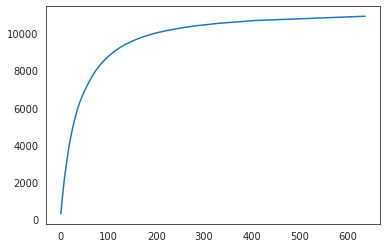

In [43]:
plt.plot(cum_count)

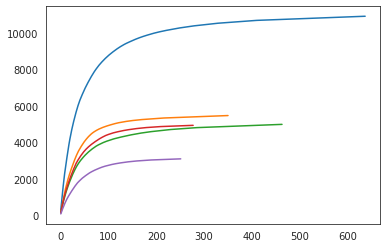

In [44]:
for df in dfs:
    data = df['count']
    plt.plot(np.cumsum(data))

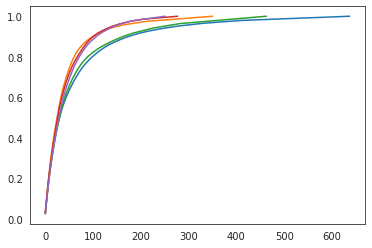

In [45]:
for df in dfs:
    data = df['count']
    cum_data = np.cumsum(data)
    nor_cum_data = cum_data/max(cum_data)
    plt.plot(nor_cum_data)

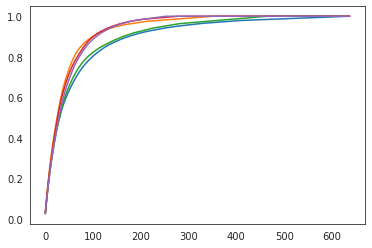

In [46]:
for df in dfs:
    data = df['count']
    cum_data = np.cumsum(data)
    nor_cum_data = cum_data/max(cum_data)

    pad_len = 638 - len(nor_cum_data)
    nor_cum_data = np.append(nor_cum_data, np.ones(pad_len))

    plt.plot(nor_cum_data)

> Selecting genes
1.   tangent = calculate_tangent(cum_counts)
2.   cum_tangent = cumulative_sum(tangent)
3.   normalized_cum_tangent = cum_tangent/max(cum_tangent)
4.   selection: genes with normalized_cum_tangent <= threshold

In [47]:
data = np.array(brca_df['count'])
cum_data = np.cumsum(data)
cum_data[:100]

array([ 291,  560,  823, 1084, 1344, 1596, 1832, 2057, 2277, 2468, 2653,
       2837, 3019, 3198, 3375, 3548, 3716, 3878, 4037, 4178, 4315, 4451,
       4583, 4704, 4824, 4939, 5051, 5157, 5262, 5366, 5465, 5564, 5658,
       5750, 5841, 5928, 6014, 6094, 6173, 6251, 6317, 6383, 6448, 6510,
       6572, 6632, 6692, 6751, 6810, 6868, 6925, 6981, 7034, 7086, 7138,
       7189, 7240, 7289, 7338, 7387, 7435, 7482, 7529, 7575, 7620, 7664,
       7708, 7751, 7793, 7835, 7876, 7916, 7955, 7992, 8028, 8064, 8100,
       8135, 8170, 8204, 8236, 8267, 8297, 8327, 8357, 8386, 8415, 8443,
       8471, 8499, 8526, 8552, 8578, 8604, 8629, 8654, 8679, 8703, 8727,
       8750])

In [48]:
diff = 5
tangent = []

for i in range(len(cum_data) - diff):
    #   y[i+d] - y[i]
    # -----------------
    #   x[i+d] - x[i]
    tan = (cum_data[i+diff] - cum_data[i]) / diff
    tangent.append(tan)
tangent = np.array(tangent)
tangent

array([261. , 254.4, 246.8, 238.6, 224.8, 211.4, 201. , 192.4, 184.2,
       181.4, 179. , 175.8, 171.8, 167.8, 160.6, 153.4, 147. , 141. ,
       133.4, 129.2, 124.8, 120. , 114.8, 111.6, 108.4, 105.2, 102.6,
       100.2,  97.6,  95. ,  92.6,  90. ,  87.2,  84.6,  82. ,  77.8,
        73.8,  70.8,  67.4,  64.2,  63. ,  61.8,  60.6,  60. ,  59.2,
        58.6,  57.8,  56.6,  55.2,  54. ,  52.8,  51.8,  51. ,  50.4,
        49.8,  49.2,  48.4,  48. ,  47.4,  46.6,  45.8,  45.2,  44.4,
        43.6,  43. ,  42.4,  41.6,  40.8,  39.8,  38.6,  37.6,  36.8,
        36. ,  35.6,  35.2,  34.4,  33.4,  32.4,  31.4,  30.6,  30. ,
        29.6,  29.2,  28.8,  28.4,  28. ,  27.4,  27. ,  26.6,  26. ,
        25.6,  25.4,  25. ,  24.6,  24.2,  23.8,  23.4,  23. ,  22.6,
        22.2,  21.8,  21.4,  21.2,  21. ,  20.8,  20.6,  20.4,  20.2,
        20. ,  19.8,  19.6,  19.4,  19. ,  18.6,  18.4,  18.2,  17.8,
        17.6,  17.4,  17.2,  16.8,  16.6,  16.2,  15.8,  15.4,  15.2,
        15. ,  15. ,

In [49]:
cum_tan = np.cumsum(tangent)
cum_tan

array([  261. ,   515.4,   762.2,  1000.8,  1225.6,  1437. ,  1638. ,
        1830.4,  2014.6,  2196. ,  2375. ,  2550.8,  2722.6,  2890.4,
        3051. ,  3204.4,  3351.4,  3492.4,  3625.8,  3755. ,  3879.8,
        3999.8,  4114.6,  4226.2,  4334.6,  4439.8,  4542.4,  4642.6,
        4740.2,  4835.2,  4927.8,  5017.8,  5105. ,  5189.6,  5271.6,
        5349.4,  5423.2,  5494. ,  5561.4,  5625.6,  5688.6,  5750.4,
        5811. ,  5871. ,  5930.2,  5988.8,  6046.6,  6103.2,  6158.4,
        6212.4,  6265.2,  6317. ,  6368. ,  6418.4,  6468.2,  6517.4,
        6565.8,  6613.8,  6661.2,  6707.8,  6753.6,  6798.8,  6843.2,
        6886.8,  6929.8,  6972.2,  7013.8,  7054.6,  7094.4,  7133. ,
        7170.6,  7207.4,  7243.4,  7279. ,  7314.2,  7348.6,  7382. ,
        7414.4,  7445.8,  7476.4,  7506.4,  7536. ,  7565.2,  7594. ,
        7622.4,  7650.4,  7677.8,  7704.8,  7731.4,  7757.4,  7783. ,
        7808.4,  7833.4,  7858. ,  7882.2,  7906. ,  7929.4,  7952.4,
        7975. ,  799

In [50]:
nor_cum_tan = np.array(cum_tan)/max(cum_tan)
nor_cum_tan

array([0.02584005, 0.05102667, 0.07546086, 0.09908322, 0.12133933,
       0.14226878, 0.16216858, 0.18121696, 0.1994535 , 0.21741283,
       0.23513455, 0.25253945, 0.26954834, 0.28616122, 0.30206126,
       0.31724848, 0.33180207, 0.34576164, 0.35896877, 0.37176009,
       0.3841158 , 0.39599628, 0.40736194, 0.41841079, 0.42914282,
       0.43955805, 0.44971586, 0.45963606, 0.46929885, 0.47870424,
       0.48787201, 0.49678237, 0.50541552, 0.51379126, 0.52190959,
       0.5296121 , 0.5369186 , 0.54392808, 0.55060095, 0.55695701,
       0.56319427, 0.56931271, 0.57531236, 0.5812526 , 0.58711364,
       0.59291527, 0.5986377 , 0.60424133, 0.60970635, 0.61505257,
       0.62027998, 0.62540839, 0.6304576 , 0.6354474 , 0.6403778 ,
       0.6452488 , 0.65004059, 0.65479278, 0.65948558, 0.66409916,
       0.66863355, 0.67310853, 0.67750431, 0.68182088, 0.68607805,
       0.69027583, 0.69439439, 0.69843376, 0.70237412, 0.70619567,
       0.70991822, 0.71356157, 0.71712572, 0.72065026, 0.72413

In [51]:
nor_cum_tan <= 0.7  # threshold

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [52]:
idx = sum(nor_cum_tan <= 0.7)
idx

68

In [53]:
def get_idx(cum_data, th):
    diff = 5
    tangent = []
    for i in range(len(cum_data) - diff):
        tan = (cum_data[i+diff] - cum_data[i]) / diff
        tangent.append(tan)
    tangent = np.array(tangent)                         # tangent with diff 5
    cum_tan = np.cumsum(tangent)                        # cumulative tangent
    nor_cum_tan = np.array(cum_tan)/max(cum_tan)        # normalized cumulative tangent
    idx = sum(nor_cum_tan < th)                         # getting index by thresholding
    return idx

68 - [70/638]
45 - [48/351]
61 - [63/464]
49 - [50/278]
52 - [53/252]


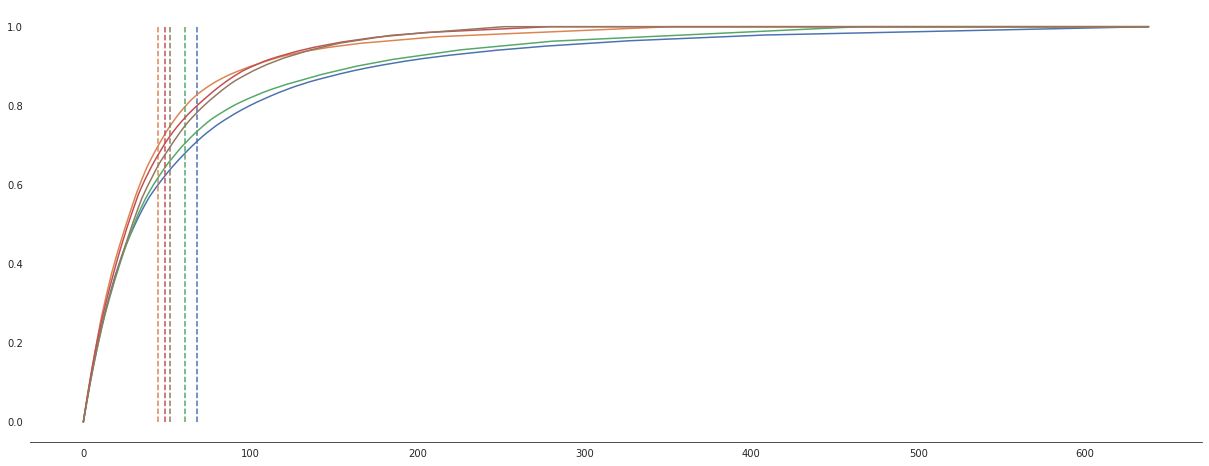

In [54]:
cp_list = ['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#937860']

plt.figure(figsize=(21, 8))
for i, df in enumerate(dfs):
    data = df['count']
    cum_data = np.cumsum(data)
    nor_cum_data = cum_data/max(cum_data)
    pad_len = 638 - len(nor_cum_data)
    nor_cum_data = np.append(nor_cum_data, np.ones(pad_len))
    nor_cum_data = np.append(np.zeros(1), nor_cum_data)
    plt.plot(range(len(nor_cum_data)), nor_cum_data, c=cp_list[i])
    # plt.legend(['brca', 'kirc', 'luad', 'prad', 'coad'], loc='center right')

    # change the value of threshold here
    threshold = 0.7
    idx = get_idx(cum_data, threshold)
    print(f'{idx} - [{data[data >= data[idx]].shape[0]}/{len(data)}]')
    plt.plot([idx]*2, range(0, 2), '--', c=cp_list[i])
sns.despine(left=True)

#### `finding best threshold`

In [69]:
dfs = [brca_df, coad_df, kirc_df, luad_df, prad_df]
threshold_dictionary = {}

for threshold in np.arange(0.05, 1.05, 0.05):
    threshold = round(threshold, 2)
    selected_idx = []
    for i, df in enumerate(dfs):
        data = df['count']
        cum_data = np.cumsum(data)
        nor_cum_data = cum_data/max(cum_data)
        pad_len = 638 - len(nor_cum_data)
        nor_cum_data = np.append(nor_cum_data, np.ones(pad_len))
        nor_cum_data = np.append(np.zeros(1), nor_cum_data)
        idx = get_idx(cum_data, threshold)
        selected_idx.append(data[data >= data[idx]].shape[0])
    threshold_dictionary[threshold] = selected_idx

In [70]:
X, y = read_dataset('dataset')

# deleting the genes which is 0 throughout the column i.e., min=max=0
X, _ = drop_cols_minmax(X)

le = LabelEncoder()
num_label = le.fit_transform(y.values)
y['Class'] = num_label
y = y.drop(columns=['type'])
y = y.values.flatten()

reading data... finished with shape: (801, 20531) and type <class 'pandas.core.frame.DataFrame'>.
reading labels... finished with shape: (801, 1) and type <class 'pandas.core.frame.DataFrame'>.
> input shape :: (801, 20531)
> deleting columns with no impact (min==max) ... ['gene_5', 'gene_23', 'gene_4370', 'gene_4808', 'gene_4809', 'gene_4814', 'gene_4816', 'gene_4817', 'gene_4831', 'gene_5288', 'gene_7661', 'gene_7662', 'gene_7663', 'gene_7664', 'gene_7665', 'gene_8121', 'gene_9304', 'gene_9306', 'gene_9314', 'gene_9316', 'gene_9320', 'gene_9452', 'gene_10121', 'gene_11958', 'gene_13991', 'gene_14158', 'gene_14159', 'gene_14161', 'gene_15138', 'gene_15140', 'gene_15141', 'gene_15446', 'gene_16566', 'gene_16568', 'gene_16569', 'gene_16571', 'gene_16575', 'gene_16578', 'gene_16579', 'gene_16604', 'gene_16634', 'gene_16637', 'gene_16677', 'gene_16697', 'gene_16698', 'gene_16699', 'gene_16700', 'gene_16701', 'gene_16702', 'gene_16704', 'gene_16705', 'gene_16706', 'gene_16707', 'gene_16708

In [71]:
def svm_acc(df, verbose=1):
    start_time = time.time()
    all_acc = []
    X = df
    iterations = 10
    for i in range(iterations):
        rs = StratifiedKFold(n_splits=10, random_state=21, shuffle=True)
        for train_index, test_index in rs.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            svm = SVC(kernel='linear')
            svm.fit(X_train, y_train)
            y_pred = svm.predict(X_test)
            acc = sum(y_test == y_pred)/len(y_pred)
            all_acc.append(acc)
            if verbose == 2:
                print(acc, end=' | ')
    end_time = time.time()
    acc = round(sum(all_acc)/len(all_acc)*100, 4)
    return acc, end_time-start_time

In [72]:
print('th (%)\tgenes_per_class\t\tunique_genes\t\taccuracy\ttime')
print('---------------------------------------------------------------------------------')

best_set = []
best_acc = 0
for threshold in np.arange(0.05, 0.85, 0.05):
    threshold = round(threshold, 2)
    selected_genes = []
    for idx, df in enumerate(dfs):
        th_idx = threshold_dictionary[threshold][idx]-1
        # print(df.loc[:th_idx, :])
        selected_genes.extend(list(df.loc[:th_idx, :].gene))
    selected_genes = set(selected_genes)

    if threshold < 0.2: sep = '\t\t\t'
    elif threshold < 0.9: sep = '\t\t'
    else: sep = '\t'
    print(f'{int(threshold*100)}\t{threshold_dictionary[threshold]}{sep}{len(selected_genes)}\t', end='\t')
    acc, t_time = svm_acc(X[selected_genes])
    print(f'{acc}\t\t{round(t_time, 2)}')

    if best_acc < acc:
        best_acc = acc
        best_set = selected_genes

th (%)	genes_per_class		unique_genes		accuracy	time
---------------------------------------------------------------------------------
5	[2, 3, 2, 3, 2]			8		86.2685		0.94
10	[5, 5, 5, 5, 4]			14		95.3796		0.81
15	[7, 7, 6, 7, 6]			18		94.5077		0.88
20	[10, 9, 9, 10, 9]		24		98.0015		0.72
25	[12, 13, 11, 13, 13]		35		99.5015		0.69
30	[15, 15, 13, 16, 14]		39		99.25		0.73
35	[19, 19, 16, 19, 17]		48		99.125		0.77
40	[23, 22, 20, 24, 20]		59		99.375		0.83
45	[28, 28, 23, 27, 24]		68		99.5		0.91
50	[33, 30, 26, 33, 28]		81		99.625		0.92
55	[39, 34, 30, 37, 33]		90		99.5		1.03
60	[49, 42, 34, 44, 37]		106		99.5		1.13
65	[57, 46, 39, 55, 43]		121		99.25		1.23
70	[70, 53, 48, 63, 50]		136		99.125		1.41
75	[85, 62, 54, 75, 58]		160		99.5		1.65
80	[104, 75, 62, 97, 71]		196		99.5		2.08


#### `rfe on best set of genes selected by best threshold`

In [73]:
len(best_set)

81

In [74]:
df = X[best_set]
df.shape

(801, 81)

In [75]:
union_res = []
ref_genes = []
for feat in range(1, 22):
    estimator = SVC(kernel="linear")
    selector = RFE(estimator, n_features_to_select=feat, step=1)
    selector = selector.fit(df, y)
    df_sel = df.loc[:, selector.support_]
    acc, t_time = svm_acc(df_sel)
    data = {'genes': sorted(list(df_sel.columns)), 'count': feat, 'acc': acc}
    union_res.append(data)

    # newly selected gene by rfe
    for g in df_sel.columns:
        if g not in ref_genes:
            ref_genes.append(g)
            break
    print(f'#feat: {feat}\tacc: {acc}\tgene: {g}  \ttime: {round(t_time, 2)}')

#feat: 1	acc: 54.2994	gene: gene_16338  	time: 0.83
#feat: 2	acc: 67.162	gene: gene_6215  	time: 0.95
#feat: 3	acc: 87.767	gene: gene_9176  	time: 0.66
#feat: 4	acc: 88.3889	gene: gene_8326  	time: 0.69
#feat: 5	acc: 95.3812	gene: gene_3540  	time: 0.66
#feat: 6	acc: 95.7562	gene: gene_11910  	time: 0.63
#feat: 7	acc: 96.1312	gene: gene_17173  	time: 0.61
#feat: 8	acc: 98.6265	gene: gene_15898  	time: 0.39
#feat: 9	acc: 98.8765	gene: gene_13801  	time: 0.41
#feat: 10	acc: 99.625	gene: gene_11409  	time: 0.44
#feat: 11	acc: 99.875	gene: gene_10916  	time: 0.45
#feat: 12	acc: 99.875	gene: gene_11698  	time: 0.43
#feat: 13	acc: 99.625	gene: gene_3541  	time: 0.42
#feat: 14	acc: 99.875	gene: gene_13413  	time: 0.45
#feat: 15	acc: 99.7515	gene: gene_203  	time: 0.46
#feat: 16	acc: 99.7515	gene: gene_15899  	time: 0.46
#feat: 17	acc: 99.875	gene: gene_19652  	time: 0.44
#feat: 18	acc: 100.0	gene: gene_228  	time: 0.44
#feat: 19	acc: 99.875	gene: gene_15792  	time: 0.44
#feat: 20	acc: 99.75	g

In [76]:
for u in union_res:
    for g in u['genes']:
        assert g in best_set

#### `binary classification: one against rest`

In [78]:
threshold = 0.5
print(threshold_dictionary[threshold])
genes_set_list = []
for idx, df in enumerate(dfs):
    th_idx = threshold_dictionary[threshold][idx]-1
    genes_set_list.append(list(df.loc[:th_idx, :].gene))

[33, 30, 26, 33, 28]


In [79]:
y_res = y

In [80]:
results = []
feature_limit = 21
for idx, l in enumerate(genes_set_list):
    df = X[l]
    y = (y_res==idx)*1
    print(f'> class: {sum(y)}/{len(y)}')
    res = []
    ref_genes = []
    for feat in range(1, feature_limit+1):
        estimator = SVC(kernel="linear")
        selector = RFE(estimator, n_features_to_select=feat, step=1)
        selector = selector.fit(df, y)
        df_sel = df.loc[:, selector.support_]
        acc, t_time = svm_acc(df_sel)

        data = {'genes': sorted(list(df_sel.columns)), 'count': feat, 'acc': acc}
        res.append(data)

        # newly selected gene by rfe
        for g in df_sel.columns:
            if g not in ref_genes:
                ref_genes.append(g)
                break
        print(f'#feat: {feat}/{df.shape[1]}\tacc: {acc}\tgene: {g}  \ttime: {round(t_time, 2)}')
        # if acc == 100:
            # break
    results.append(res)
    print()

> class: 300/801
#feat: 1/33	acc: 68.7824	gene: gene_6698  	time: 0.74
#feat: 2/33	acc: 83.7701	gene: gene_6694  	time: 0.74
#feat: 3/33	acc: 84.5262	gene: gene_15242  	time: 0.77
#feat: 4/33	acc: 86.8966	gene: gene_15300  	time: 0.77
#feat: 5/33	acc: 88.517	gene: gene_7148  	time: 0.77
#feat: 6/33	acc: 93.1312	gene: gene_16338  	time: 0.7
#feat: 7/33	acc: 96.7546	gene: gene_13801  	time: 0.64
#feat: 8/33	acc: 97.5	gene: gene_4053  	time: 0.67
#feat: 9/33	acc: 97.5	gene: gene_1322  	time: 0.7
#feat: 10/33	acc: 97.625	gene: gene_7899  	time: 0.74
#feat: 11/33	acc: 98.0	gene: gene_7112  	time: 0.7
#feat: 12/33	acc: 98.1265	gene: gene_19739  	time: 0.75
#feat: 13/33	acc: 97.5015	gene: gene_10916  	time: 0.76
#feat: 14/33	acc: 97.8765	gene: gene_18392  	time: 0.75
#feat: 15/33	acc: 97.8765	gene: gene_9230  	time: 0.78
#feat: 16/33	acc: 98.5	gene: gene_18039  	time: 0.82
#feat: 17/33	acc: 98.375	gene: gene_4042  	time: 0.77
#feat: 18/33	acc: 98.25	gene: gene_552  	time: 0.82
#feat: 19/33	ac

In [81]:
results

[[{'acc': 68.7824, 'count': 1, 'genes': ['gene_6698']},
  {'acc': 83.7701, 'count': 2, 'genes': ['gene_6694', 'gene_6698']},
  {'acc': 84.5262,
   'count': 3,
   'genes': ['gene_15242', 'gene_6694', 'gene_6698']},
  {'acc': 86.8966,
   'count': 4,
   'genes': ['gene_15242', 'gene_15300', 'gene_6694', 'gene_6698']},
  {'acc': 88.517,
   'count': 5,
   'genes': ['gene_15242',
    'gene_15300',
    'gene_6694',
    'gene_6698',
    'gene_7148']},
  {'acc': 93.1312,
   'count': 6,
   'genes': ['gene_15242',
    'gene_15300',
    'gene_16338',
    'gene_6694',
    'gene_6698',
    'gene_7148']},
  {'acc': 96.7546,
   'count': 7,
   'genes': ['gene_13801',
    'gene_15242',
    'gene_15300',
    'gene_16338',
    'gene_6694',
    'gene_6698',
    'gene_7148']},
  {'acc': 97.5,
   'count': 8,
   'genes': ['gene_13801',
    'gene_15242',
    'gene_15300',
    'gene_16338',
    'gene_4053',
    'gene_6694',
    'gene_6698',
    'gene_7148']},
  {'acc': 97.5,
   'count': 9,
   'genes': ['gene_13